In [1]:
import numpy as np 
from scipy.integrate import quad 
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pathos.multiprocessing import ProcessingPool
from functools import partial
from matplotlib.colors import LogNorm
import pandas as pd
import datetime

/tmp/ipykernel_11647/2892871457.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [32]:
def phi_0(k_length) -> float:
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.cos(w * t + phase)
    return val


def cos_integral(t, T, omega, phi):
    return 1/64*(-(4*T*np.sin(2*((np.pi*t)/T + t*omega + phi)))/(T*omega + np.pi) 
                 + (T*np.sin(2*((2*np.pi*t)/T + t*omega + phi)))/(T*omega + 2*np.pi)
                 - (4*T*np.sin((2*np.pi*t)/T - 2*(t*omega + phi)))/(np.pi - T*omega) 
                 + (T*np.sin((4*np.pi*t)/T - 2*(t*omega + phi)))/(2*np.pi - T*omega) 
                 - (8*T*np.sin((2*np.pi*t)/T))/np.pi + (T*np.sin((4*np.pi*t)/T))/np.pi 
                 + (6*np.sin(2*phi)*np.cos(2*t*omega))/omega + (6*np.cos(2*phi)*np.sin(2*t*omega))/omega 
                 + 12*t)


def sin_integral(t, T, omega, phi):
    return 1/64*((4*T*np.sin(2*((np.pi*t)/T + t*omega + phi)))/(T*omega + np.pi) 
                 - (T*np.sin(2*((2*np.pi* t)/T + t*omega + phi)))/(T*omega + 2*np.pi)
                 + (4*T*np.sin((2*np.pi*t)/T - 2*(t*omega + phi)))/(np.pi - T*omega) 
                 + (T*np.sin((4*np.pi*t)/T - 2*(t*omega + phi)))/(T*omega - 2*np.pi)
                 - (8* T *np.sin((2*np.pi* t)/T))/np.pi + (T* np.sin((4*np.pi* t)/T))/np.pi
                 - (6* np.sin(2* phi) *np.cos(2* t* omega))/omega 
                 - (6*np.cos(2*phi)*np.sin(2*t*omega))/omega + 12*t)


def sin2sin(t, omega, phase, T):
    plus_pi = omega + np.pi * 2 / T
    minus_pi = omega - np.pi * 2 / T
    cos_terms = (-1 / plus_pi * np.cos(plus_pi * t + phase) -
                           1 / minus_pi * np.cos(minus_pi * t + phase) +
                           2 / omega * np.cos(omega * t + phase))
    return cos_terms

def sin2cos(t, omega, phase, T):
    plus_pi = omega + np.pi * 2 / T
    minus_pi = omega - np.pi * 2 / T
    sin_terms = (1 / plus_pi * np.sin(plus_pi * t + phase) + 1 / minus_pi * np.sin(minus_pi * t + phase) -
                 2 / omega * np.sin(omega * t + phase))
    return sin_terms

i = complex(0, 1)

def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             cos2_zero, sin2_zero, cos_zero, sin_zero
            ) -> float:
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (
                     k[0] * (sin2cos(t=ts, omega=w_s, phase=phase_s, T=T_s) - cos_zero) +
                     k[1] * epsilon * (sin2sin(t=ts, omega=w_s, phase=phase_s, T=T_s) - sin_zero)
                                                 ) 
                 # A_0**2
                  + A_0**2 / (1 + epsilon**2) * (cos_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 cos2_zero +
                                              epsilon**2 * (sin_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 sin_zero)
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, complex_func=True, limit=10)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (
                     k[0] * (sin2cos(t=ts, omega=w_s, phase=phase_s, T=T_s) - cos_zero) +
                     k[1] * epsilon * (sin2sin(t=ts, omega=w_s, phase=phase_s, T=T_s) - sin_zero)
                                                 ) 
                 # A_0**2
                  + A_0**2 / (1 + epsilon**2) * (cos_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 cos2_zero +
                                              epsilon**2 * (sin_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) -
                                                 sin_zero)
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, complex_func=True, limit=10)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k_squared) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    
    
def plot_log(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals, norm=LogNorm())

    ax.invert_yaxis()

    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
    ax.tick_params(direction="inout", right=True, top=True)

    cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    plt.show()
    
    return


def plt_pkl(file: str, log: bool = True):
    df = pd.read_pickle(file)
    if log:
        return plot_log(df["kx"], 
                        df["ky"], 
                        df["dpdk"])
    else:
        return plot(df["kx"], 
                df["ky"], 
                df["dpdk"])

def plt_pkl_diff(file2: str, file1: str, log: bool = True):
    df1 = pd.read_pickle(file2)
    df2 = pd.read_pickle(file1)
    df = df1.copy()
    df["dpdk1"] = df1["dpdk"] - df2["dpdk"]
    if log:
        return plot_log(df["kx"], 
                        df["ky"], 
                        df["dpdk1"])
    else:
        return plot(df["kx"], 
                df["ky"], 
                df["dpdk1"])
    

def plot(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals)

    ax.tick_params(direction="inout", right=True, top=True)
    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

    fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    return

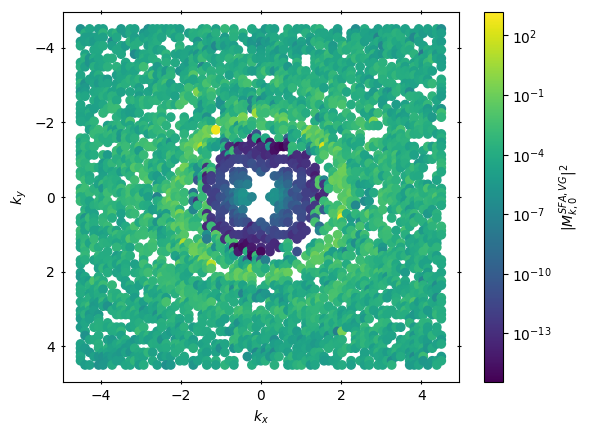

In [3]:
plt_pkl_diff("A2_is_0_15_windows.pkl", "Standard.pkl", log=True)

### Standard values

In [4]:
I = 5e13
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_s = w_800 * 800 / 400 # 300 nm

A_0_s = F_0 / w_s

E_0_s = -13.6 / conversion_ev_au

N_s = 30
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 1
A_0_s, A_0_s**2

(0.32915874037472703, 0.10834547636507695)

In [5]:
k_test = np.array([1, 1, 0])

cos2_zero = cos_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin2_zero = sin_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin_zero = sin2sin(t=0, T=T_s, omega=w_s, phase=phase_s)
cos_zero = sin2cos(t=0, T=T_s, omega=w_s, phase=phase_s)

val = M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s, cos2_zero=cos2_zero, sin2_zero=sin2_zero, cos_zero=cos_zero, 
               sin_zero=sin_zero)

/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:446: IntegrationWarning: The maximum number of subdivisions (10) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:449: IntegrationWarning: The maximum number of subdivisions (10) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the 

In [6]:
dp_dk(val)

0.047123631325151426

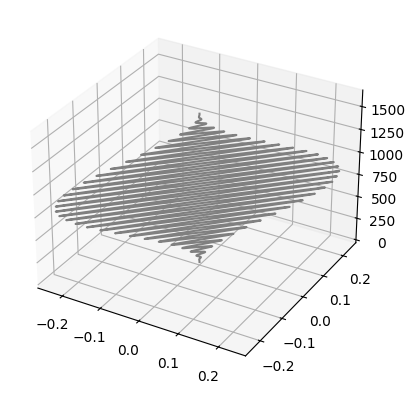

In [7]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [27]:
tic = datetime.datetime.now()
def compute_values(kx, kys, T_s, w_s, A_0_s, E_0_s, phase_s):
    return [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s, cos2_zero=cos2_zero, sin2_zero=sin2_zero, cos_zero=cos_zero,
                           sin_zero=sin_zero, epsilon=1, T_f=T_s)) for ky in kys]

length = 201

start_val_x = -2
end_val_x = 2

start_val_y = -2
end_val_y = 2

kxs = np.linspace(start_val_x, end_val_x, length)
kys = np.linspace(start_val_y, end_val_y, length)

cos2_zero = cos_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin2_zero = sin_integral(t=0, T=T_s, omega=w_s, phi=phase_s)
sin_zero = sin2sin(t=0, T=T_s, omega=w_s, phase=phase_s)
cos_zero = sin2cos(t=0, T=T_s, omega=w_s, phase=phase_s)

# Create a pool of worker processes using pathos
pool = ProcessingPool()  

# Create a partial function with fixed arguments except for kx
partial_compute_values = partial(
    compute_values, kys=kys, T_s=T_s, w_s=w_s, A_0_s=A_0_s, E_0_s=E_0_s, phase_s=phase_s)

# Map the partial function to kxs
results = pool.map(partial_compute_values, kxs)

kx_plot = np.repeat(kxs, length)
ky_plot = np.tile(kys, length)
values_plot = np.concatenate(results)

toc = datetime.datetime.now()
print(f"Finished, length: {length}, time: {toc - tic}")


Finished, length: 201, time: 0:04:00.972459


Functions, time: 25.381660 length: 10
Quads, time: 1:27.857284 length: 10 3.6 forbedring 

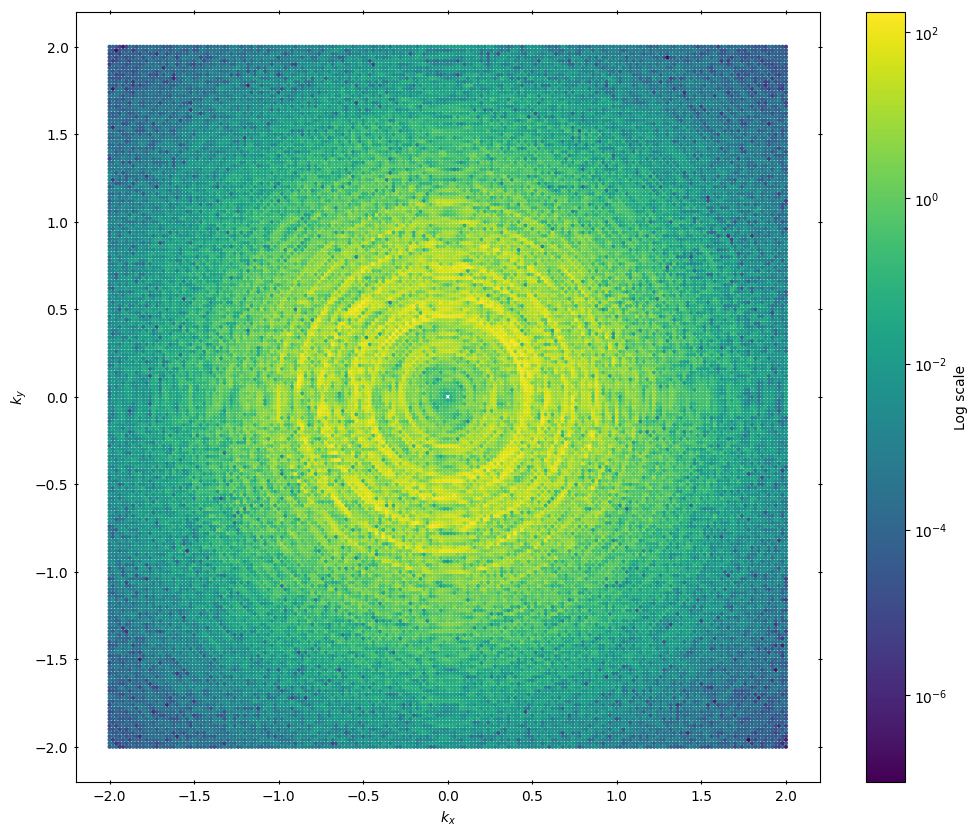

In [28]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, norm=LogNorm(), s=4)

ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
ax.tick_params(direction="inout", right=True, top=True)

cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
cbar.ax.set_ylabel('Log scale')

plt.show()

### Old method

In [38]:
from scipy.stats import gaussian_kde

In [40]:
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
x, y = data.T
nbins = 20
k = gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [43]:
kx_plot

array([-2., -2., -2., ...,  2.,  2.,  2.])

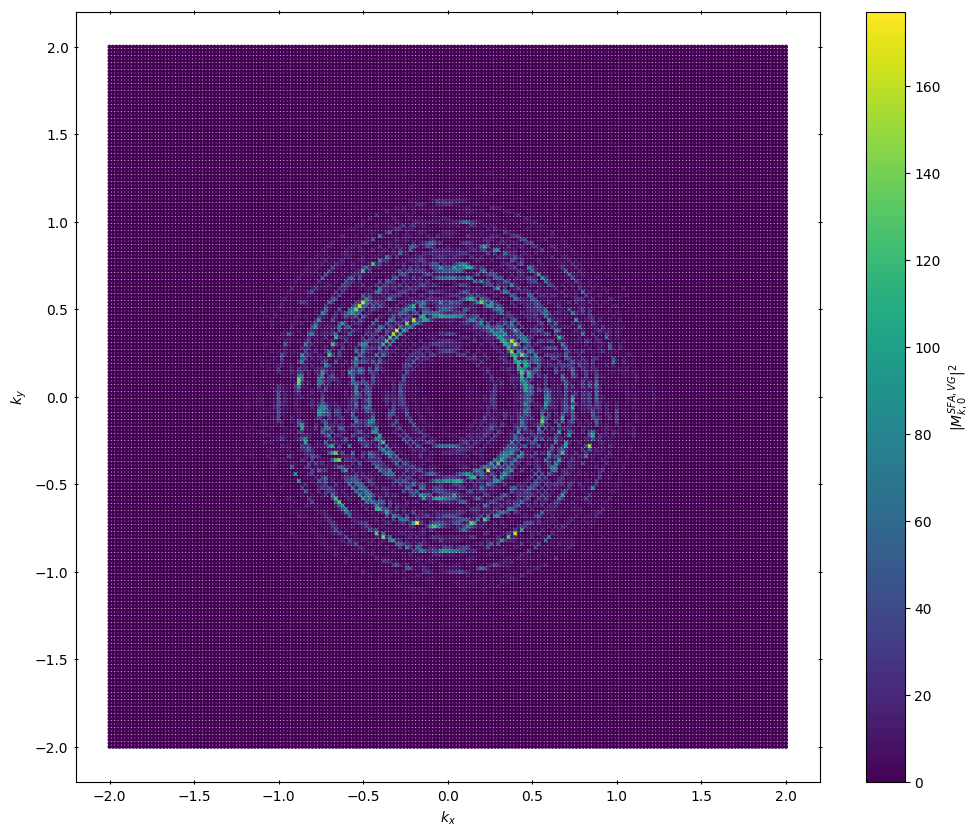

In [35]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, s=4)

ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')

In [30]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot
df.to_pickle("New_Standard_N_.pkl")

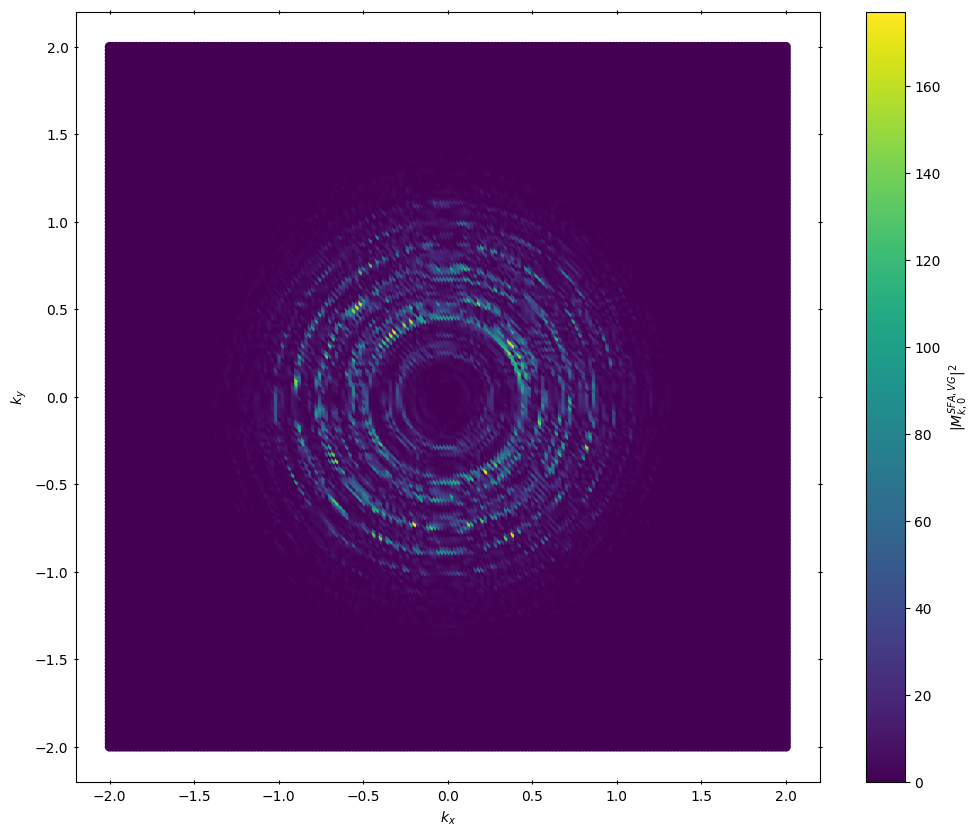

In [34]:
plt_pkl("New_Standard_N_.pkl", log=False)

In [17]:
df_std = pd.read_pickle("Standard.pkl")

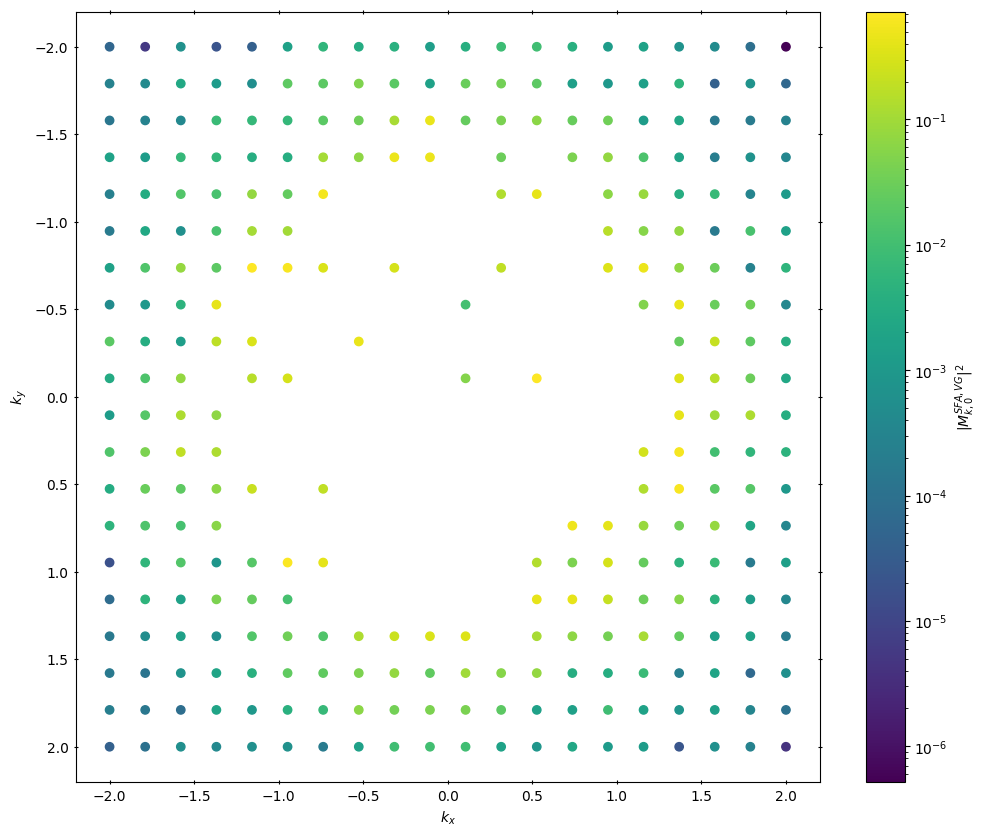

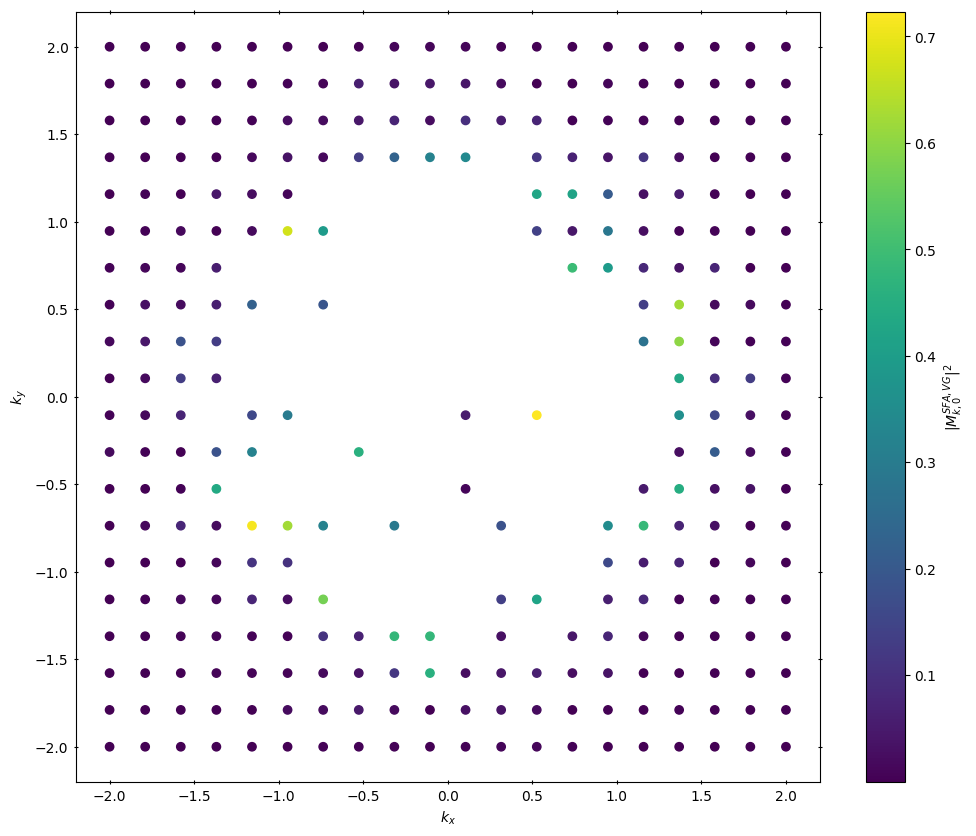

In [19]:
plt.rcParams['figure.figsize'] = (12, 10)  # Change the numbers to adjust width and height

#plt_pkl("A2_is_0_15_windows.pkl", log=True)
plt_pkl("Standard.pkl", log=True)
plt_pkl("Standard.pkl", log=False)

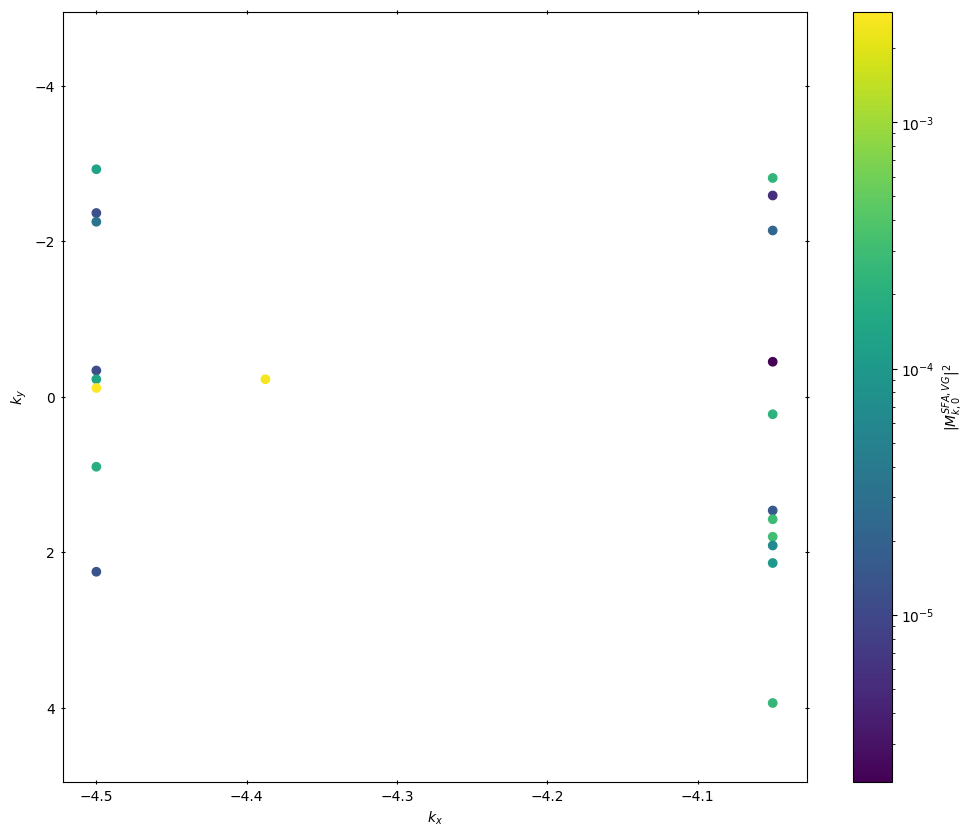

In [20]:
plt_pkl_diff("A2_is_0_15_windows.pkl", "Standard.pkl", log=True)

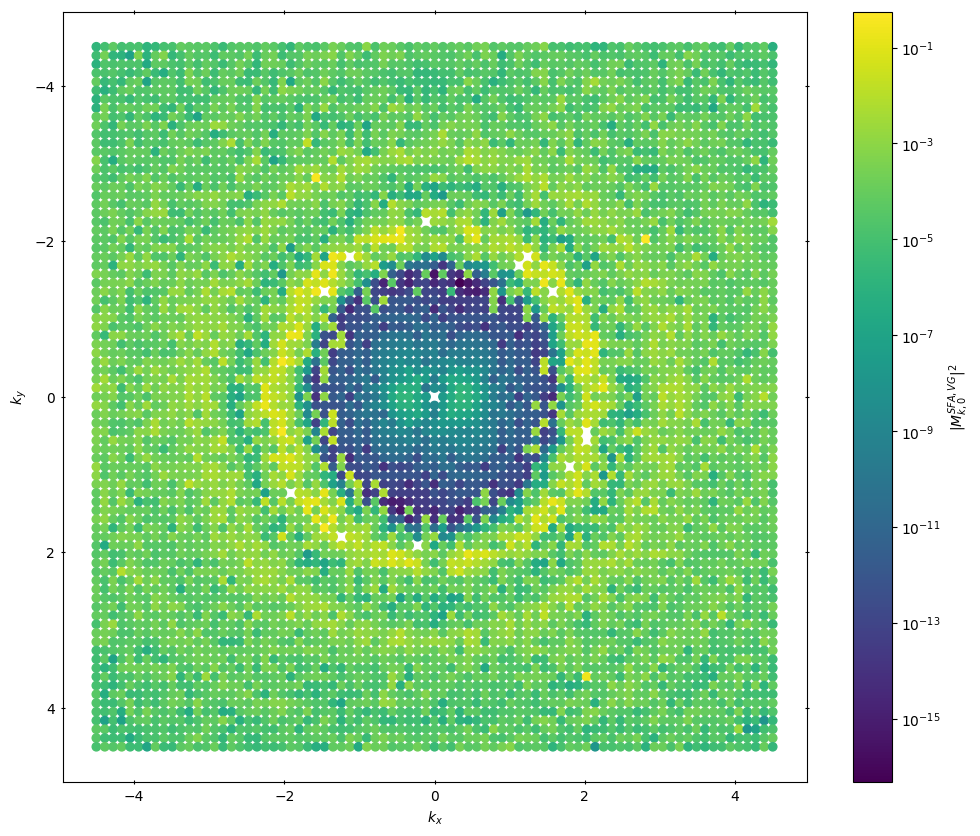

In [21]:
plt_pkl("A2_is_0_15_windows.pkl", log=True)

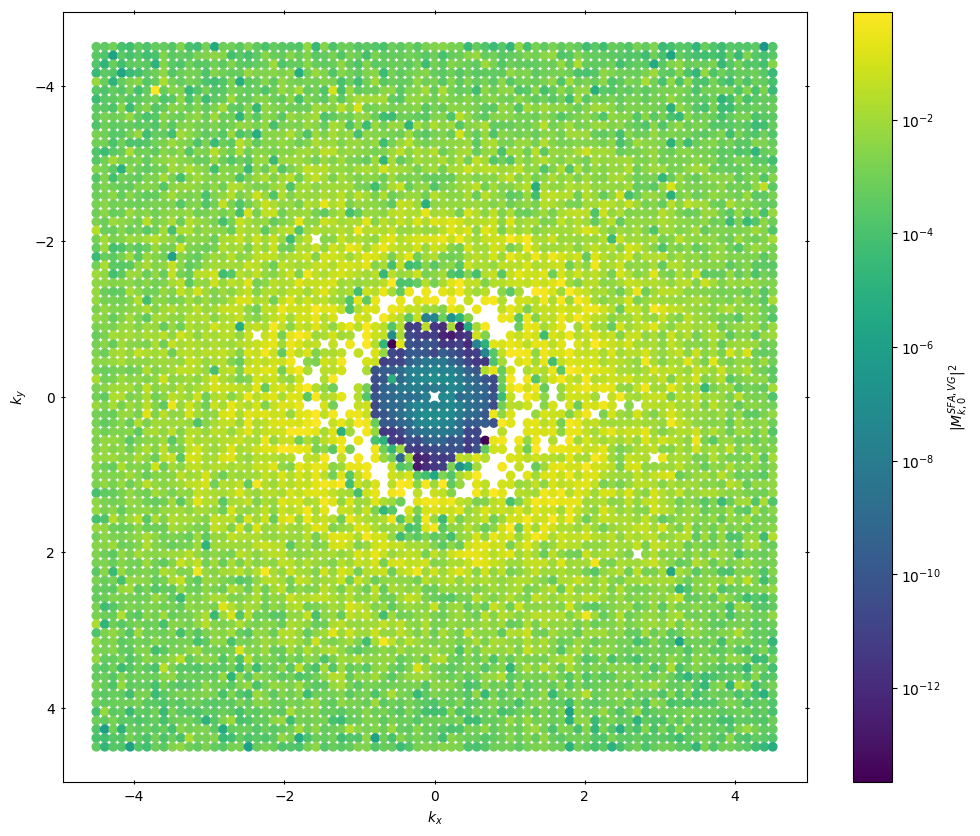

In [22]:
plt_pkl("ws_er_2ws_19_windows.pkl", log=True)

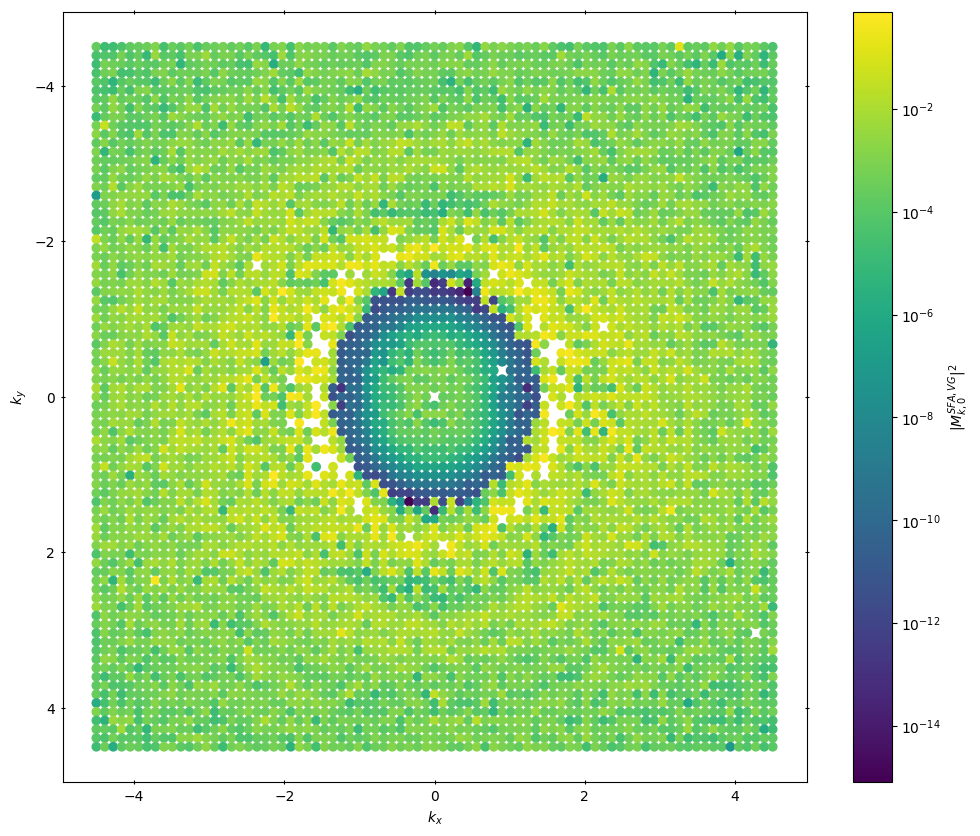

In [23]:
plt_pkl("I_er_e14_23_windows.pkl", log=True)

In [24]:
dd = pd.read_pickle("0002_windows.pkl")

In [25]:
dd.loc[dd["kx"]==0]

kx   ky          dpdk
3240  0.0 -4.0  2.239314e-04
3241  0.0 -3.9  9.176132e-05
3242  0.0 -3.8  3.962459e-06
3243  0.0 -3.7  2.879579e-06
3244  0.0 -3.6  6.725667e-08
...   ...  ...           ...
3316  0.0  3.6  1.556280e-05
3317  0.0  3.7  3.591826e-06
3318  0.0  3.8  2.020527e-05
3319  0.0  3.9  1.716384e-06
3320  0.0  4.0  6.690087e-05

[81 rows x 3 columns]

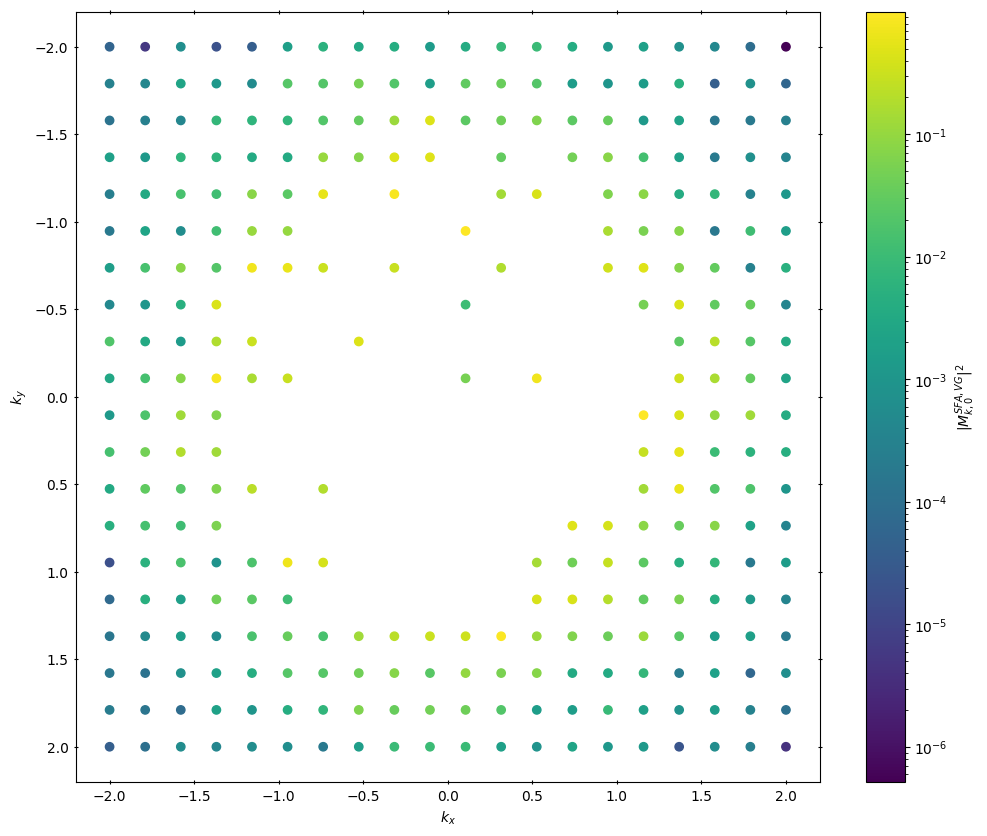

In [26]:
plot_log(df.loc[df["dpdk"] < 1, "kx"], df.loc[df["dpdk"] < 1, "ky"], df.loc[df["dpdk"] < 1, "dpdk"])

length = 5
start_val = -4
end_val = 4
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)



kx_plot = []
ky_plot = []
values_plot = []
for i, kx in enumerate(kxs):
    values = [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]
    print(i)
    kx_plot.extend(kx * np.ones(length))
    ky_plot.extend(kys)
    values_plot.extend(values)
        